In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# train_test_split
from sklearn.model_selection import train_test_split

# Student's T-Test
from scipy.stats import ttest_ind

# Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Train/Test Split

In [4]:
train_data = pd.read_csv('data/train.csv')
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
X_train, X_test = train_test_split(train_data, test_size=0.25, random_state=42)

## Data Exploration

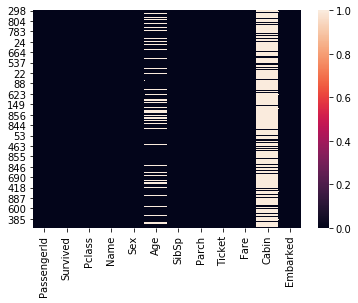

In [6]:
sns.heatmap(X_train.isna())

In [7]:
# Survival Rate
print('Survival Rate: {:0.2f}%'.format(X_train.Survived.value_counts()[1] * 100 / X_train.Survived.count()))

# Survival Rate by Gender
print('Survival Rate by Gender:')

print('\tFemale: {:0.2f}%'.format(X_train.groupby('Sex').Survived.mean()['female'] * 100))
print('\tMale: {:0.2f}%'.format(X_train.groupby('Sex').Survived.mean()['male'] * 100))

# Survival Rate by Pclass
print('Survival Rate by Pclass:')

print(X_train.groupby('Pclass').Survived.mean())

Survival Rate: 37.87%
Survival Rate by Gender:
	Female: 74.24%
	Male: 18.91%
Survival Rate by Pclass:
Pclass
1    0.611842
2    0.482270
3    0.245333
Name: Survived, dtype: float64


Survival Rate by Age:
Survived
0    30.249211
1    28.223014
Name: Age, dtype: float64
Statistical Significance:
	T-Statistic: 1.5897314241282023
	P-Value: 0.11248718974067941


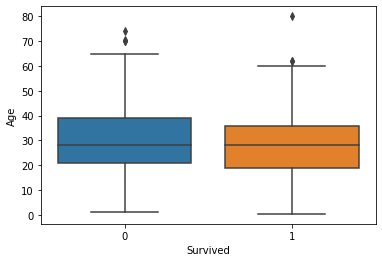

In [8]:
# Survival Rate by Age
print('Survival Rate by Age:')
sns.boxplot(
    x='Survived',
    y='Age',
    data=X_train
)

print(X_train.groupby('Survived').Age.mean())

# Difference statistically significant?
stat, p = ttest_ind(X_train[X_train.Survived == 0].Age.dropna(), X_train[X_train.Survived == 1].Age.dropna())
print('Statistical Significance:')
print('\tT-Statistic: {}'.format(stat))
print('\tP-Value: {}'.format(p))

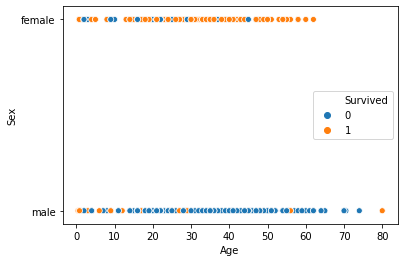

In [9]:
sns.scatterplot(
    x='Age',
    y='Sex',
    hue='Survived',
    data=X_train
)

In [10]:
# Baselines
print('Baselines')

# If I predict that everyone dies
print('If I predict that everyone survives: {:0.2f}%'.format((X_train.Survived == 0).mean() * 100))

# If I predict that all females live
print('If I predict that all females live: {:0.2f}%'.format((X_train.Sex == 'female').mean() * 100))

# If I predict that all females live and all males die
print('If I predict that all females live and all males die: {:0.2f}%'.format(pd.concat([X_train[X_train.Sex == 'male'].Survived == 0, X_train[X_train.Sex == 'female'].Survived == 1]).mean() * 100))

Baselines
If I predict that everyone survives: 62.13%
If I predict that all females live: 34.28%
If I predict that all females live and all males die: 78.74%


## Feature Engineering

In [11]:
X_train.loc[(X_train.Sex == 'female') & (X_train.Pclass == 2)].Age.mean()

28.33653846153846

In [12]:
def feature_engineer(data):
    data_copy = data.copy()

    # Impute Age
    genders = ['male', 'female']

    for g in genders:
        data_copy.loc[data_copy.Sex == g, 'Age'] = data_copy.loc[data_copy.Sex == g].Age.mean()

    # Get Cabin Letter
    data_copy['Cabin_letter'] = data_copy.Cabin.fillna('_').str[0]

    # Get Mode for Embarked
    modeEmbarked = data_copy['Embarked'].mode()
    data_copy.Embarked.fillna(modeEmbarked, inplace=True)

    # One-Hot Encoding
    cat_cols = [
        'Pclass',
        'Sex',
        'Embarked'
    ]
    for col in cat_cols:
        data_copy = data_copy.join(pd.get_dummies(data_copy[col], prefix=col, drop_first=True))

    # Normalize Numeric Features (Z-Score)
    num_cols = [
        'Age',
        'Fare',
        'SibSp',
        'Parch'
    ]
    for col in num_cols:
        col_name = col + '_normalized'
        data_copy[col_name] = data_copy[col].apply(lambda x: (x - data_copy[col].mean()) / data_copy[col].std())

    # Drop Old + Misc columns
    data_copy.drop([
        'PassengerId',
        'Sex',
        'Name',
        'Ticket',
        'Cabin',
        'Cabin_letter',
        'Embarked',
        'Age',
        'Fare',
        'SibSp',
        'Parch',
        'Pclass'
    ], axis=1, inplace=True)

    return data_copy.drop('Survived', axis=1), data_copy['Survived'], data_copy

In [13]:
X_train_final, y_train_final, train_final = feature_engineer(X_train)
X_test_final, y_test_final, test_final = feature_engineer(X_test)
print(X_train_final.columns)

Index(['Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Age_normalized', 'Fare_normalized', 'SibSp_normalized',
       'Parch_normalized'],
      dtype='object')


## Model Building

In [14]:
def print_confusion_matrix(y_test, y_pred):
    print('Confusion Matrix:')
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)
    print('Accuracy: {:0.2f}%'.format((matrix[0][0] + matrix[1][1]) * 100 / matrix.sum()))
    print('Recall: {:0.2f}%'.format(matrix[0][0] * 100 / (matrix[0][0] + matrix[1][0])))
    print('Precision: {:0.2f}%'.format(matrix[0][0] * 100 / (matrix[0][0] + matrix[0][1])))

In [15]:
# Logistic Regression
lr = LogisticRegression(max_iter = 2000)
lr.fit(X_train_final, y_train_final)
y_pred = lr.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

# Logistic Regression Coefficients
print('Feature Coefficients:')
for i in range(len(X_train_final.columns)):
    print('\t' + X_train_final.columns[i] + ': {:0.6f}'.format(lr.coef_[0][i]))

Confusion Matrix:
[[113  21]
 [ 28  61]]
Accuracy: 78.03%
Recall: 80.14%
Precision: 84.33%
Feature Coefficients:
	Pclass_2: -0.094065
	Pclass_3: -1.233671
	Sex_male: -0.490256
	Embarked_Q: -0.265731
	Embarked_S: -0.574023
	Age_normalized: -1.031545
	Fare_normalized: 0.278975
	SibSp_normalized: -0.252265
	Parch_normalized: -0.098314


In [16]:
# SVC
svc = SVC(probability=True)
svc.fit(X_train_final, y_train_final)
y_pred = svc.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[120  14]
 [ 30  59]]
Accuracy: 80.27%
Recall: 80.00%
Precision: 89.55%


In [17]:
from xgboost import XGBClassifier

# XGBClassifier
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train_final, y_train_final)
y_pred = xgb.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[107  27]
 [ 27  62]]
Accuracy: 75.78%
Recall: 79.85%
Precision: 79.85%


In [18]:
from sklearn.naive_bayes import GaussianNB

# GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_final, y_train_final)
y_pred = gnb.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[112  22]
 [ 25  64]]
Accuracy: 78.92%
Recall: 81.75%
Precision: 83.58%


## Model Tuning

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score:', classifier.best_score_)
    print('Best Parameters:', classifier.best_params_)
    print('Best Index:', classifier.best_index_)

In [20]:
# Linear Regression
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf_lr = clf_lr.fit(X_train_final, y_train_final)
clf_performance(best_clf_lr, 'Logistic Regression')

lr = best_clf_lr.best_estimator_
y_pred = lr.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

print('Feature Coefficients:')
for i in range(len(X_train_final.columns)):
    print('\t' + X_train_final.columns[i] + ': {:0.6f}'.format(lr.coef_[0][i]))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8008865447200091
Best Parameters: {'C': 0.23357214690901212, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Index: 17
Confusion Matrix:
[[115  19]
 [ 27  62]]
Accuracy: 79.37%
Recall: 80.99%
Precision: 85.82%
Feature Coefficients:
	Pclass_2: 0.094300
	Pclass_3: -0.926639
	Sex_male: -0.275625
	Embarked_Q: -0.129575
	Embarked_S: -0.407979
	Age_normalized: -1.075698
	Fare_normalized: 0.361484
	SibSp_normalized: -0.256906
	Parch_normalized: -0.101778


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished


In [26]:
# SVC
svc = SVC(probability = True)

param_grid = tuned_parameters = [
    {
        'kernel': ['rbf'],
        'gamma': [.1,.5,1,2,5,10],
        'C': [.1, 1, 10, 100, 1000]
    },
    # {
    #     'kernel': ['linear'],
    #     'C': [.1, 1, 10, 100, 1000]
    # },
    # {
    #     'kernel': ['poly'],
    #     'degree' : [2,3,4,5],
    #     'C': [.1, 1, 10, 100, 1000]
    # }
]

clf_svc = GridSearchCV(svc, param_grid=param_grid, cv=20, verbose=True, n_jobs=-1)
best_clf_svc = clf_svc.fit(X_train_final, y_train_final)
clf_performance(best_clf_svc, 'SVC')

svc = best_clf_svc.best_estimator_
y_pred = svc.predict(X_test_final)

# Confusion Matrix
print_confusion_matrix(y_test_final, y_pred)

Fitting 20 folds for each of 30 candidates, totalling 600 fits
SVC
Best Score: 0.8081996434937612
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Index: 6
Confusion Matrix:
[[119  15]
 [ 27  62]]
Accuracy: 81.17%
Recall: 81.51%
Precision: 88.81%


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    6.3s finished


In [27]:
# SVC w/ optimized parameters
svc = SVC(probability=True, C=1, gamma=0.1, kernel='rbf')

svc.fit(X_train_final, y_train_final)
y_pred = svc.predict(X_test_final)

print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[119  15]
 [ 27  62]]
Accuracy: 81.17%
Recall: 81.51%
Precision: 88.81%


In [25]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_final, y_train_final)
y_pred = rfc.predict(X_test_final)

print_confusion_matrix(y_test_final, y_pred)

Confusion Matrix:
[[115  19]
 [ 29  60]]
Accuracy: 78.48%
Recall: 79.86%
Precision: 85.82%
